<a href="https://colab.research.google.com/github/kennynakamura/WordCloudConversaWhatsApp/blob/main/WhatsAppWordCloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Pip install para o colab
!pip install emoji
!pip install nltk
!pip install wordcloud

In [ ]:
#@title Bibliotecas Python
import re
import emoji
import plotly
import pickle
import numpy as np
import pandas as pd
from os import path
from pathlib import Path
import plotly.express as px
from pandas import DataFrame
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

In [ ]:
#@title Funções
def starts_with_date_time(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+)[ ]([0-9]+):([0-9]+)[ ]-'
    result = re.match(pattern, s)
    if result:
        return True
    return False

def find_author(s):
  s=s.split(":")
  if len(s) > 1:
    return True
  else:
    return False

def split_count(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)
    return emoji_list

def get_data_point(line):
    split_l = line.split(' - ')
    date_time = split_l[0]
    date, time = date_time.split(' ')
    message = ' '.join(split_l[1:])
    split_msg = message.split(': ')
    author = split_msg[0]
    message = ' '.join(split_msg[1:])
    return date, time, author, message

def tiraroculto(dataframe):
  dataframe = dataframe.drop(df[df.message =='<Arquivo de mídia oculto>'].index)
  return dataframe

def limpar_texto(text):
    
    text = "".join(text)
    remove_punct = str.maketrans('', '', string.punctuation)
    text = text.translate(remove_punct)
    remove_digits = str.maketrans('', '', string.digits)
    text = text.lower().translate(remove_digits)
    text = re.sub(r'([a-z])\1+', r'\1', text)
    tokens = word_tokenize(text)
    stop_words = stopwords.words('portuguese')
    tokens_stop = [y for y in tokens if y not in stop_words]

    final = []
    for item in tokens_stop:
        div = item.split()
        for i in div:
           cont = i.count('k') + i.count('ha') + i.count('hsu') + i.count('rs')
           if cont >= 1:
              tokens_stop.remove(item)

    dd = ' '.join(map(str,tokens_stop))
    final.append(dd)
    return final

def tirar_msg_nula_dalista(listadotexto):
   for item in listadotexto:
     if item == "":
       listadotexto.remove(item)
   return listadotexto 

def palavrasnuvem(palavras):
   tudo = [j for i in palavras for j in i]
   tudo = ' '.join(tudo)
   tudo = tudo.split(' ')
   for item in tudo:
     if len(item) < 4:
       tudo.remove(item)
   return tudo

def wordfreq_sub(tagger,portuguese_sent_tokenizer, text):
  sentences = portuguese_sent_tokenizer.tokenize(text)
  tags = [tagger.tag(nltk.word_tokenize(sentence)) for sentence in sentences]
  flat_list = [item for sublist in tags for item in sublist]
  flat_list
  ListasSUB = []
  ListasADJ = []
  for element in flat_list: 
     if element[1] == "NOUN":
        ListasSUB.append(element[0]) 
     if element[1] == "ADJ":
        ListasADJ.append(element[0])
  ListasTotal = ListasADJ + ListasSUB
  wordfreq = {}
  for item in ListasTotal:
     if item not in wordfreq:
        wordfreq[item] = 0 
     wordfreq[item] += 1
  wordfreq = {k:v for k,v in wordfreq.items() if v > 2}
  wordfreq = {k: v for k, v in sorted(wordfreq.items(), key=lambda item: item[1])}
  return wordfreq

In [ ]:
#Criação do DataFrame a partir de Conversa do WhatsApp

parsed = []

#Criar pasta "data" na pasta raiz
#colocar as conversas "Conversa com ...".txt nesta pasta
directory = "/content/data/"

import glob
for filepath in glob.iglob(directory + '*.txt'):
  with open(filepath, encoding="utf-8") as fp:
       fp.readline()
       name = Path(filepath).stem
       msg_buffer = []
       date, time, author = None, None, None
       while True:
          line = fp.readline()
          if not line:
              break
          line = line.strip()
          if starts_with_date_time(line):
              if len(msg_buffer) > 0:
                  parsed.append([date, time, author, ' '.join(msg_buffer), name])
              msg_buffer.clear()
              date, time, author, message = get_data_point(line)
              msg_buffer.append(message)
          else:
              msg_buffer.append(line)

df = pd.DataFrame(parsed, columns=['date', 'time', 'author', 'message', 'name'])
df["date"] = pd.to_datetime(df["date"])

df = tiraroculto(df)

#Retirada de apenas as mensagens e limpeza
mensagem = df["message"]
mensagemmod = list(mensagem)
ff = []
for item in mensagemmod:
   item = limpar_texto(item)
   item = tirar_msg_nula_dalista(item)
   ff.append(item)
listapalavras = [x for x in ff if x != []]
result = palavrasnuvem(listapalavras)
text = ' '.join(result)

In [ ]:
#StopWords com adição de palavras para serem excluidas
#adicionar o arquivo stopwords.txt na pasta raiz, "/content/"

stopwords= set(STOPWORDS)
new_words = []
with open("/content/stopwords.txt", 'r') as f:
    [new_words.append(word) for line in f for word in line.split()]

new_stopwords = stopwords.union(new_words)

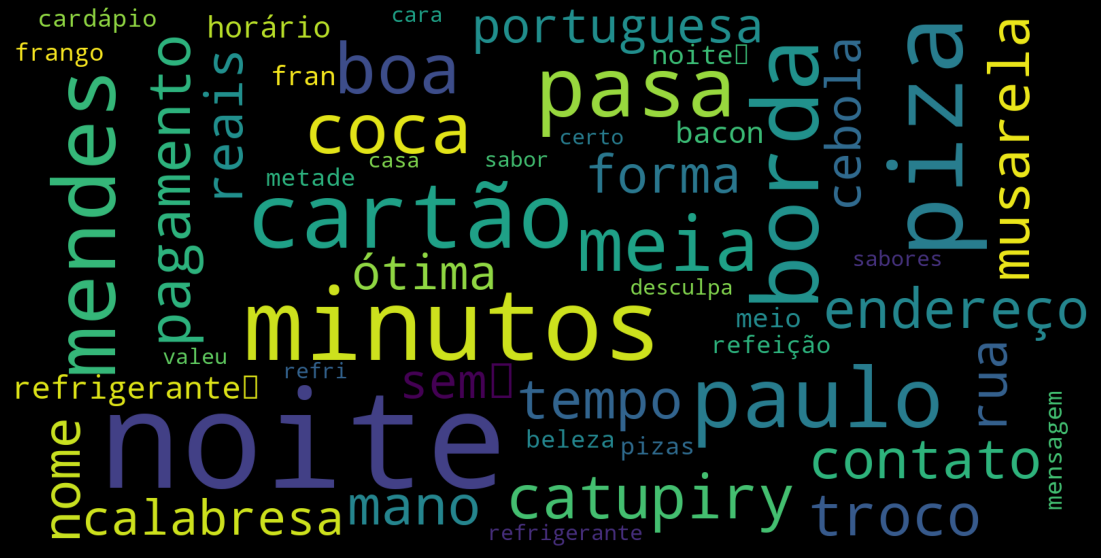

In [ ]:
#Nuvem de Palavras de Substantivos e Adjetivos
#adicionar o arquivo tagger.pkl na pasta raiz, "/content/"

tagger = pickle.load(open("/content/tagger.pkl",'rb'))
portuguese_sent_tokenizer = nltk.data.load("tokenizers/punkt/portuguese.pickle")
wordfreq = wordfreq_sub(tagger,portuguese_sent_tokenizer,text)

wordcloud = WordCloud(stopwords=new_stopwords,max_font_size=200,
                      max_words=100,width=1600, height=800).generate_from_frequencies(wordfreq)
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('wordcloud_sub_adj.png', facecolor='k', bbox_inches='tight')

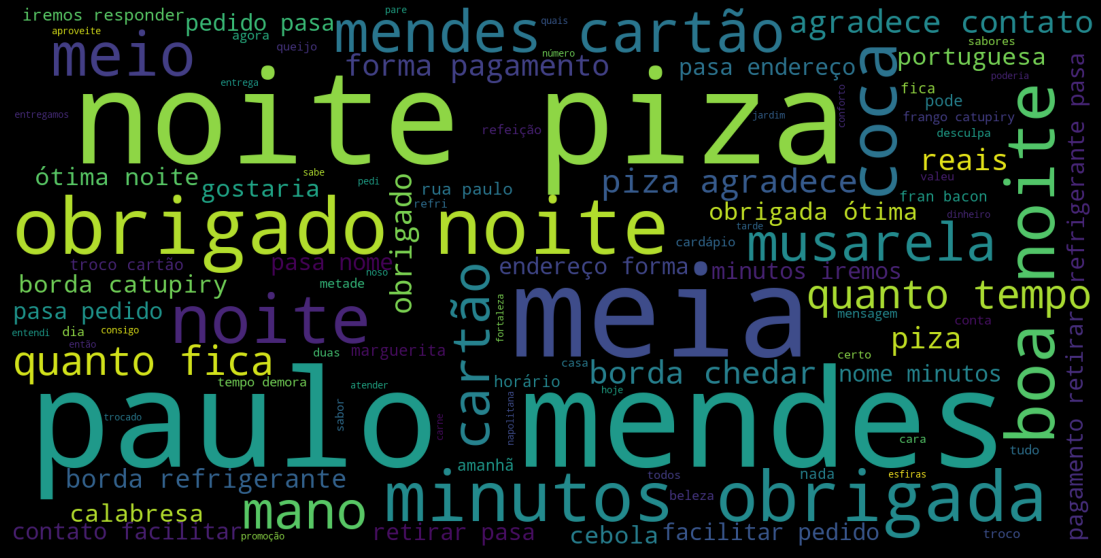

In [ ]:
#Nuvem de Palavras de todo texto 

wordcloud = WordCloud(stopwords=new_stopwords,max_font_size=200,
                      max_words=100,width=1600, height=800).generate(text)
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('wordcloud.png', facecolor='k', bbox_inches='tight')